# Finetune Codestral on your Github repo

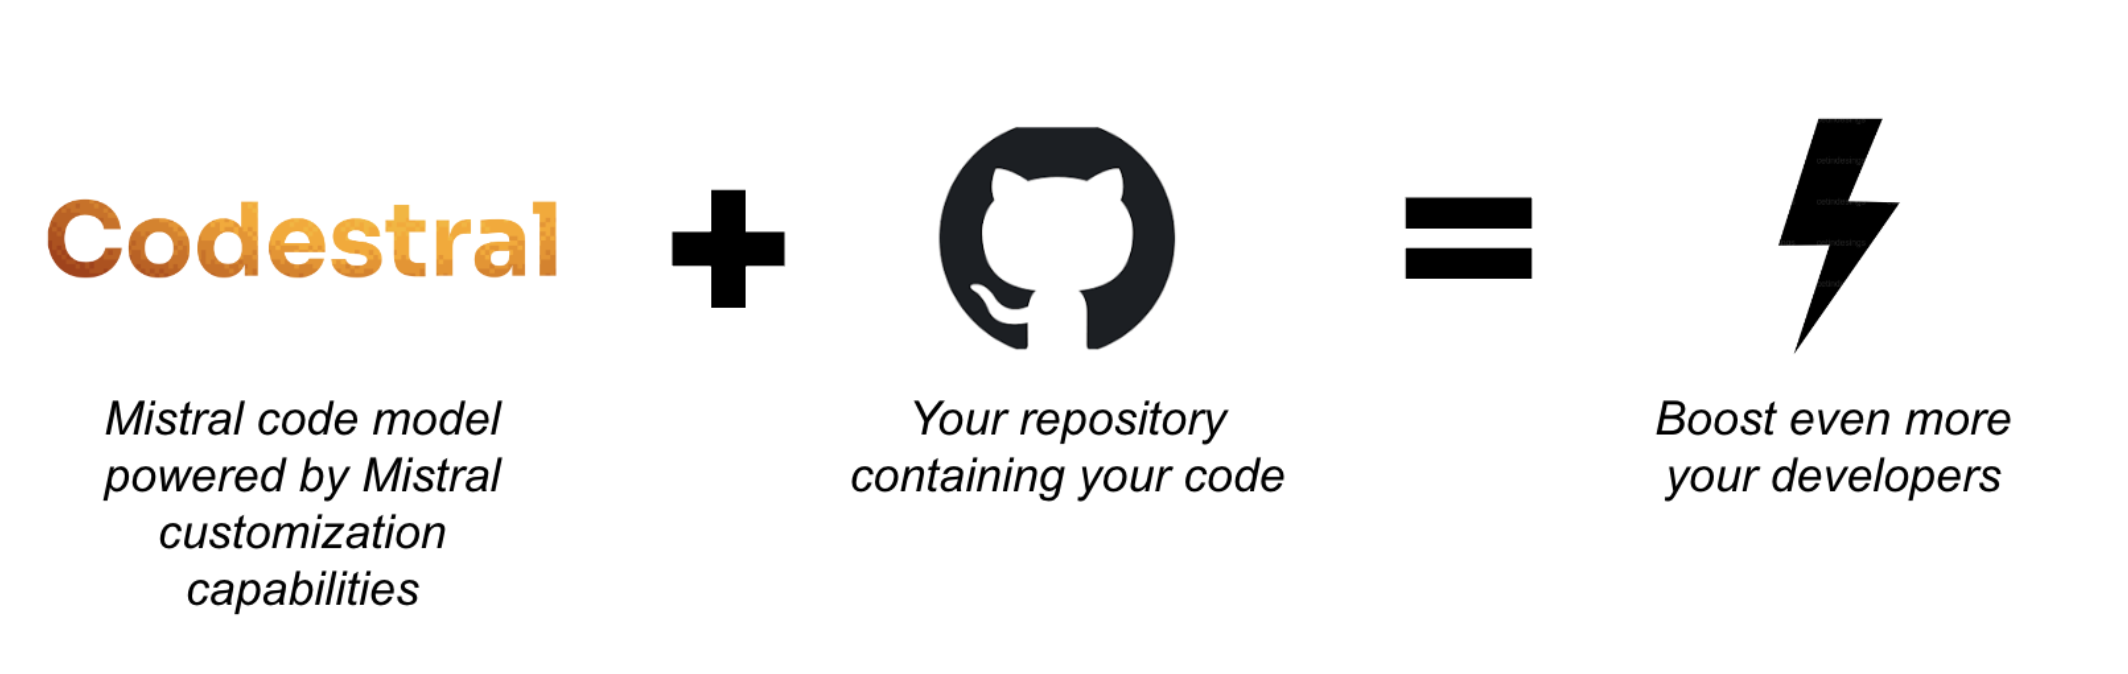

Finetuning your Codestral model on your Github repository presents various advantages.

- Accuracy :
Model understands context and nuances of your codebase

- Productivity :
Developers spend less time on correcting suggestions

- Consistency :
Model helps enforcing best practices and reduce variability in coding styles

- Security :
Model complies with specific regulations and internal policies to meets all necessary standards

# Import needed packages

The first step is to install the needed packages `mistralai` and import the needed packages :

In [ ]:
! pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.1 MB/s eta 0:00:00
/bin/bash: line 1: matplotlib.pyplot: command not found


In [ ]:
from mistralai import Mistral
from getpass import getpass
import matplotlib.pyplot as plt

# Access Github repo

To access programatically to the repo you want to finetune you must generate a github Fine-grained token.
Generate your token in the `Settings/Developer Settings` of your Github profile.

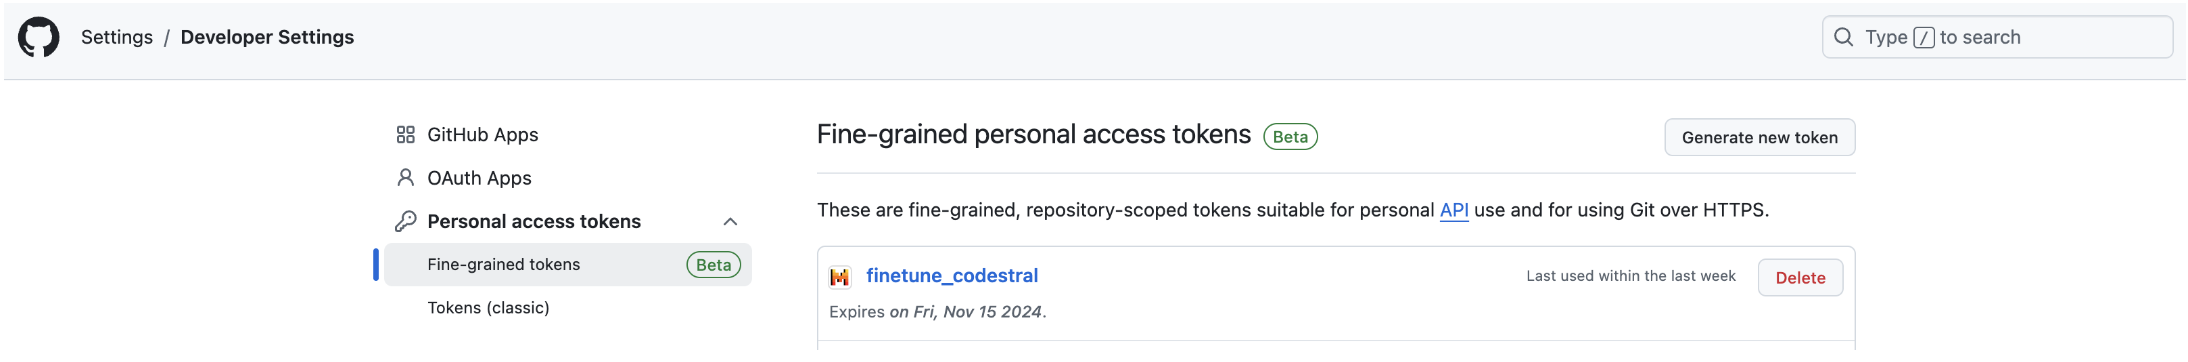

In [24]:
api_key= getpass("Type your API Key")
github_token =  getpass("Type your Github token")

client = Mistral(api_key=api_key)

Type your API Key··········
Type your Github token··········


## Launch the finetuning job

In this example we will finetune Codestral on two MistralAI open source repos :
- https://github.com/mistralai/mistral-inference
- https://github.com/mistralai/client-python

Note that you are free to add multiple repos if you want. These repos will be fed to Codestral that will be trained in a FIM mode on each of the files.

You can choose the hyperparameters configuration of your choice.

Make sure to only run this cell once not to create several jobs at the same time. 

In [ ]:
created_jobs = client.fine_tuning.jobs.create(
    model="codestral-latest",
    auto_start=True,
    repositories=[
        {
            "type": "github",
            "owner": "mistralai",
            "name": "mistral-inference",
            "token":github_token
        },
        {
            "type": "github",
            "owner": "mistralai",
            "name": "client-python",
            "token":github_token
        }
    ],
    hyperparameters={
        "training_steps": 100,
        "learning_rate":0.0001
    }
)

created_jobs

JobOut(id='1d7ed1e8-59df-4132-9680-26c1ba9845a8', auto_start=True, hyperparameters=TrainingParameters(training_steps=100, learning_rate=0.0001, weight_decay=0.1, warmup_fraction=0.05, epochs=None, fim_ratio=0.9), model='codestral-latest', status='QUEUED', job_type='FT', created_at=1729236281, modified_at=1729236282, training_files=[], validation_files=[], OBJECT='job', fine_tuned_model=None, suffix=None, integrations=[], trained_tokens=None, repositories=[GithubRepositoryOut(name='mistral-inference', owner='mistralai', commit_id='fffa5dac372280e5810d8008e54f70b1a5c40bde', TYPE='github', ref='main', weight=1.0), GithubRepositoryOut(name='client-python', owner='mistralai', commit_id='9f487dc998e948a52e17bcaa9aace5ccfa92571b', TYPE='github', ref='main', weight=1.0)], metadata=JobMetadataOut(expected_duration_seconds=None, cost=0.0, cost_currency=None, train_tokens_per_step=None, train_tokens=None, data_tokens=None, estimated_start_time=None))

## Follow training performance

Run this cell while training is happening to follow the evolution of performances.

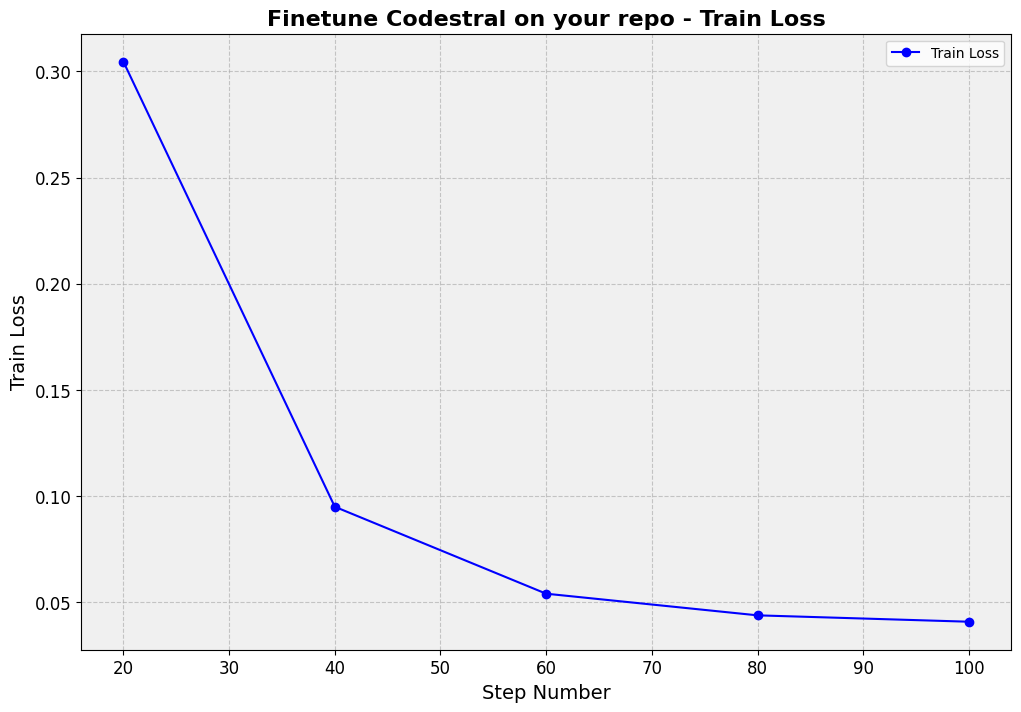

In [15]:
# Extract step_number and train_loss from the job data
retrieved_job = client.fine_tuning.jobs.get(job_id = created_jobs.id)
step_numbers = [checkpoint.step_number for checkpoint in retrieved_job.checkpoints]
train_losses = [checkpoint.metrics.train_loss for checkpoint in retrieved_job.checkpoints]

# Plot the data
plt.figure(figsize=(12, 8))
plt.plot(step_numbers, train_losses, marker='o', linestyle='-', color='b', label='Train Loss')

# Adding titles and labels
plt.title('Finetune Codestral on your repo - Train Loss', fontsize=16, fontweight='bold')
plt.xlabel('Step Number', fontsize=14)
plt.ylabel('Train Loss', fontsize=14)

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(loc='best')

# Customizing the appearance
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding a background color
plt.gca().set_facecolor('#f0f0f0')

# Display the plot
plt.show()

## Access the finetuned model

You can now easily use the finetuned model as if it was a generic Mistral model.
Let's test a model with a prefix/suffix prompt.

Note that it's expected for the first few requests to take a little more time as the Lora weights need to be stored in memory.

In [26]:
prompt = """def sample_top_p(probs: torch.Tensor, p: float) -> torch.Tensor:"""
suffix = "return torch.gather(probs_idx, -1, next_token)"

response = client.fim.complete(
    model=retrieved_job.fine_tuned_model,
    prompt=prompt,
    suffix=suffix
)

print(
    f"""
{prompt}
{response.choices[0].message.content}
{suffix}
"""
)


def sample_top_p(probs: torch.Tensor, p: float) -> torch.Tensor:


    assert 0 <= p <= 1

    probs_sort, probs_idx = torch.sort(probs, dim=-1, descending=True)
    probs_sum = torch.cumsum(probs_sort, dim=-1)
    mask = probs_sum - probs_sort > p
    probs_sort[mask] = 0.0
    probs_sort.div_(probs_sort.sum(dim=-1, keepdim=True))
    
return torch.gather(probs_idx, -1, next_token)

